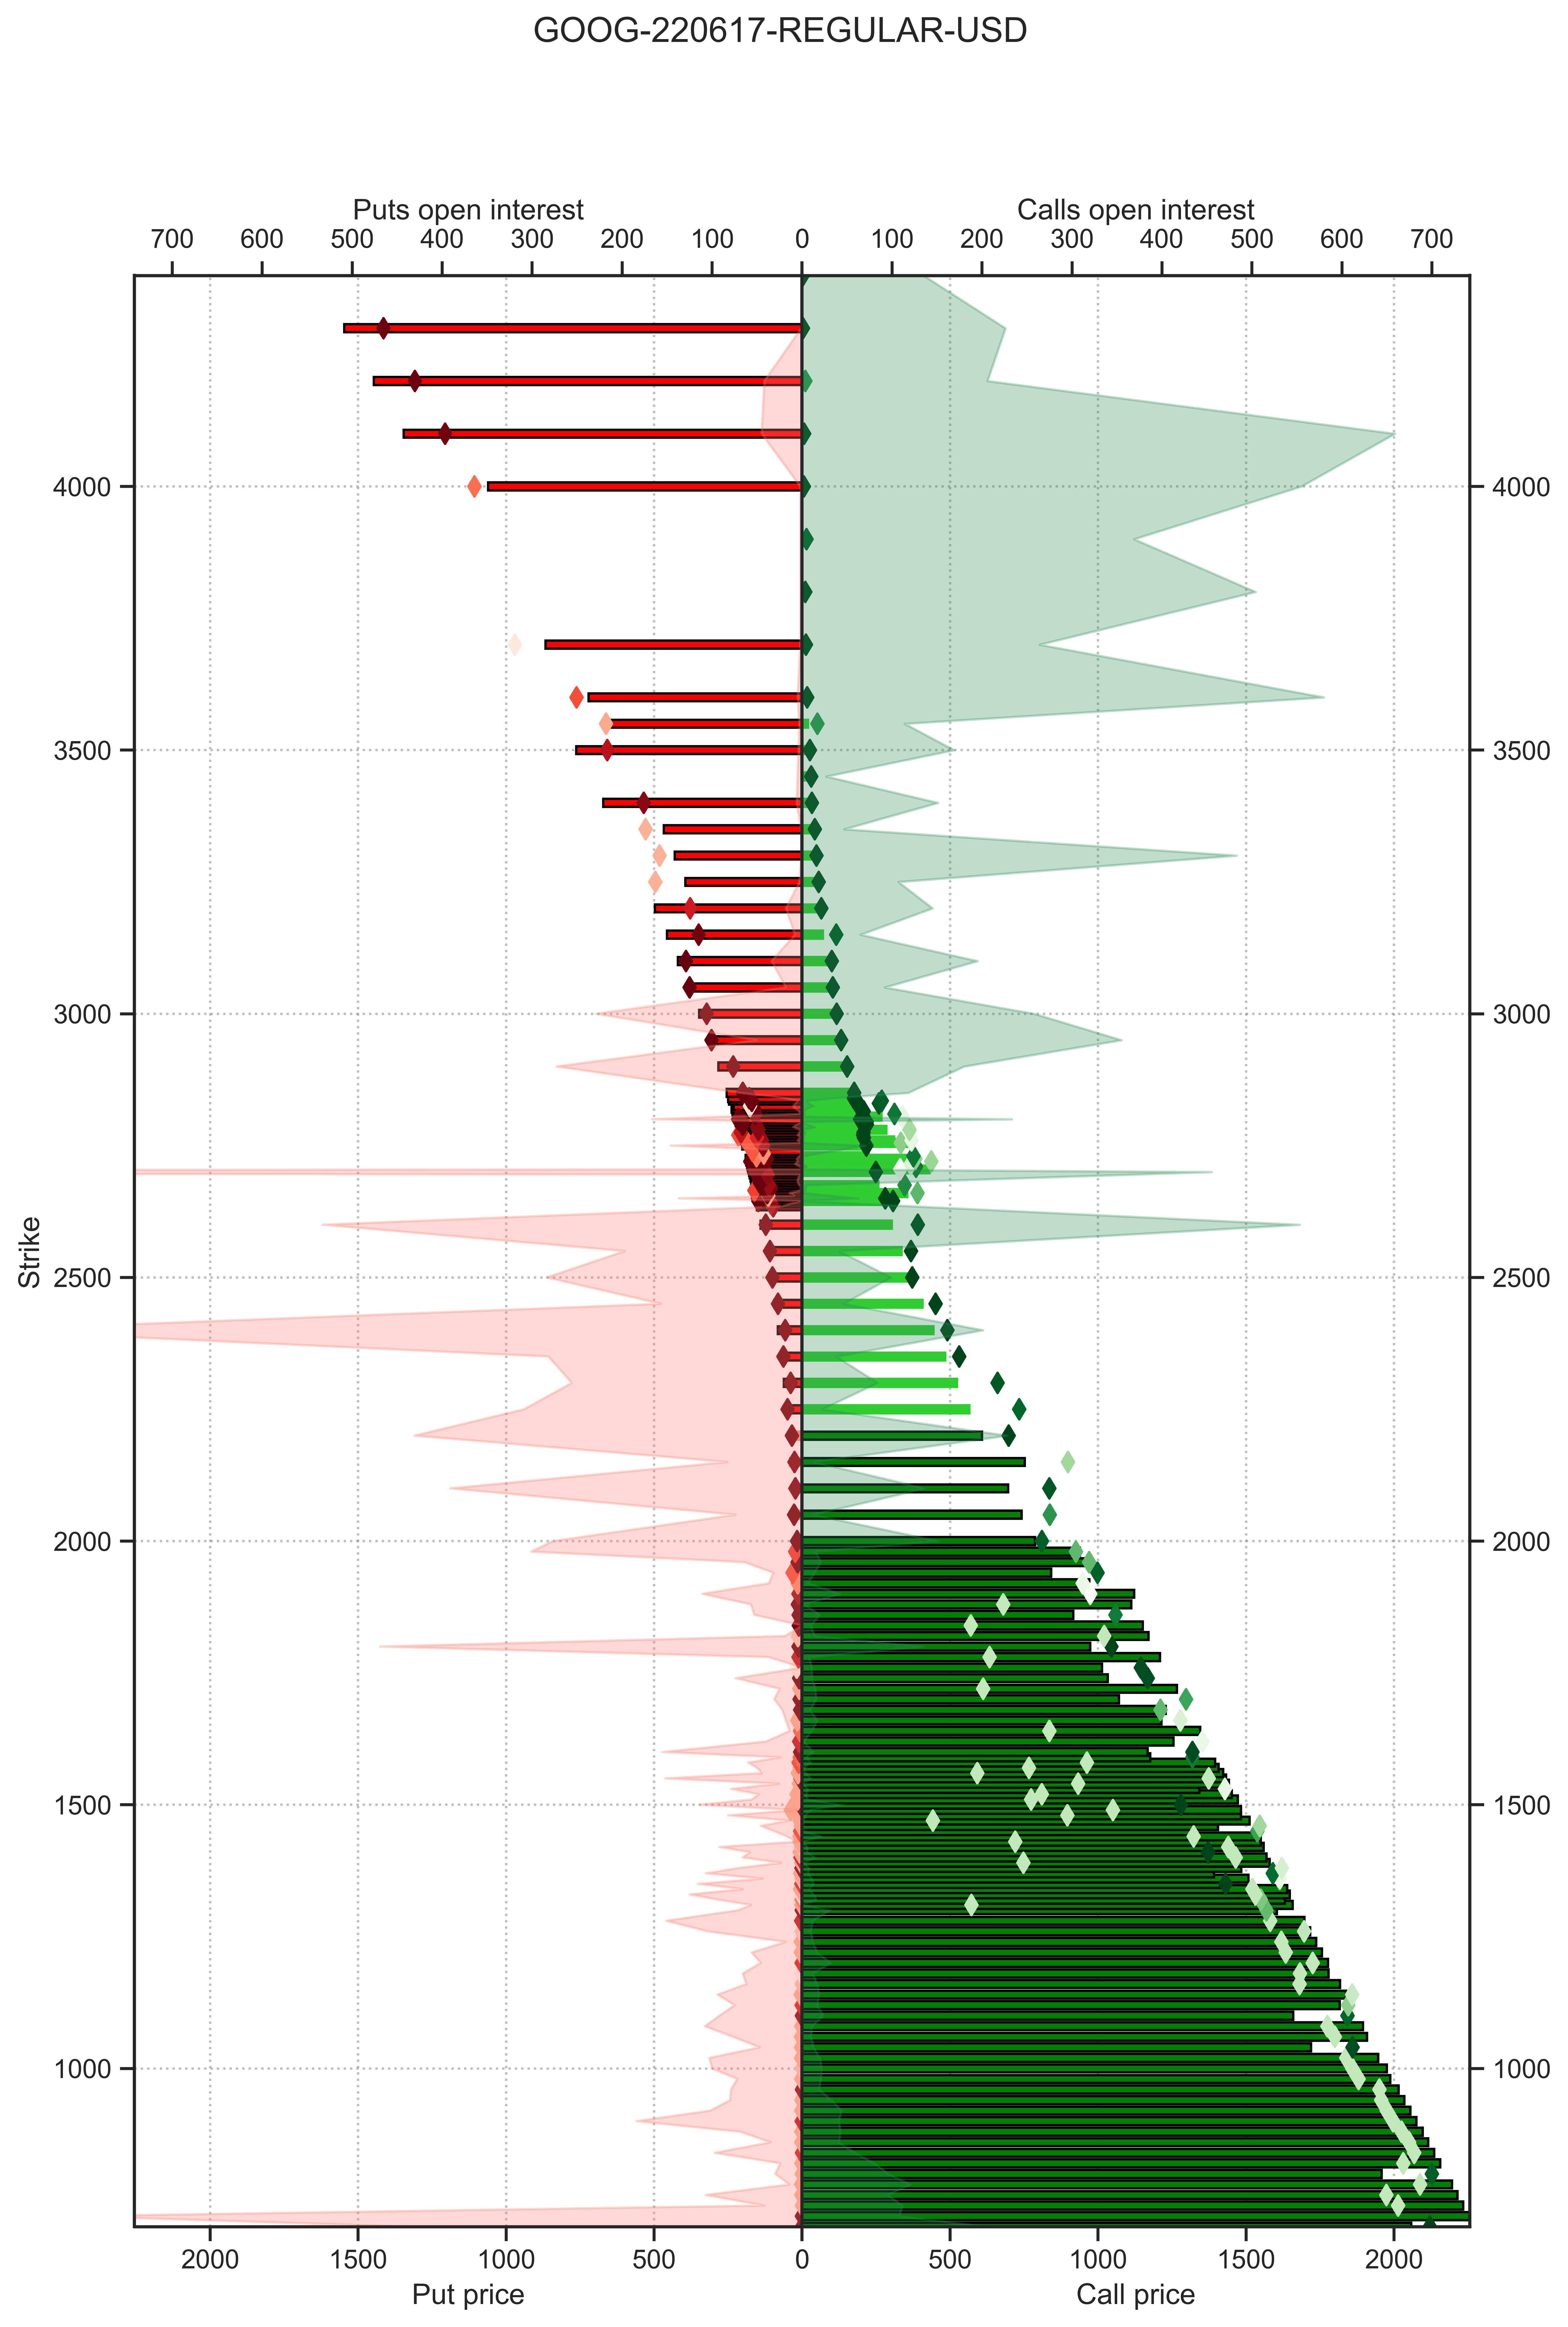

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set(rc={'figure.dpi':600, 'savefig.dpi':600})
plt.style.use('seaborn-ticks')

df = pd.read_csv('data.xlsx')

df.lastTradeDate = pd.to_datetime(df.lastTradeDate)
timezone = df.iloc[0].lastTradeDate.tzinfo
df['timeDelta'] = (df.lastTradeDate - pd.to_datetime("today", utc=timezone))
df['timeDelta'] = df['timeDelta'].apply(pd.Timedelta.total_seconds)

df['mid'] = (df.bid + df.ask)/2

cols = ['strike', 
        'lastPrice',
        'openInterest',
        'inTheMoney',
        'timeDelta',
        'mid'
        ]

puts = (df[df.type=='Put'][cols]
        .set_index('strike')
        .sort_index()
        )
puts['ITM'] = np.where(puts.inTheMoney==1, 
                       puts.mid, 
                       np.nan)
puts['OTM'] = np.where(puts.inTheMoney==0, 
                       puts.mid, 
                       np.nan)

calls = (df[df.type=='Call'][cols]
        .set_index('strike')
        .sort_index()
        )
calls['ITM'] = np.where(calls.inTheMoney==1, 
                        calls.mid, 
                        np.nan)
calls['OTM'] = np.where(calls.inTheMoney==0, 
                        calls.mid, 
                        np.nan)

# ----------------------------- CHART -----------------------------
# 2 subplots, 6 figures total (3x figures per subplot)

# 1.1. Bar chart:
    # 1.1.1 Puts - ITM (darker, with border)
    # 1.1.2 Puts - OTM
# 1.2 Scatter plot: puts - last price
    # Color shading shows time delta of the last trade (vs. today):
        # darker -> more recent trade
# 1.3 Area chart: puts - open interest

# 2.1. Bar chart:
    # 2.1.1 Calls - ITM (darker, with border)
    # 2.1.2 Calls - OTM
# 2.2 Scatter plot: calls - last price
    # Color shading shows time delta of the last trade (vs. today):
        # darker -> more recent trade
# 2.3 Area chart: calls - open interest


# hard-coded for this data set
frac_maxOI = 0.2
maxOI = max(df.openInterest)*frac_maxOI

minStrike = min(df.strike)
maxStrike = max(df.strike)
maxMid    = max(df.mid)
alphaOI = 0.3
bars_height = 15

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,1]})
fig.set_size_inches(10, 15)
fig.subplots_adjust(wspace=0)

size   = df.iloc[0].contractSize
ccy    = df.iloc[0].currency
expiry = df.iloc[0].contractSymbol[4:10]
ticker = df.iloc[0].ticker
title  = f'{ticker}-{expiry}-{size}-{ccy}'
fig.suptitle(title)

grid_kwargs = {'visible'   : True, 
               'which'     : 'major', 
               'color'     : 'gray', 
               'linestyle' : ':',
               'alpha'     : 0.5}
               

# --------------------- PUTS ---------------------
# 1.1.1 Puts - ITM
ax1.barh(y=puts.index,
         width=puts.ITM,
         height=bars_height,
         color='red',
         edgecolor='black'
         )
# 1.1.2 Puts - OTM
ax1.barh(y=puts.index,
         width=puts.OTM,
         height=bars_height,
         color='lightcoral',
         edgecolor='lightcoral'
         )
ax1.set_ylim(minStrike, maxStrike)
ax1.yaxis.tick_left()
ax1.set_xlim(maxMid,0)
ax1.set_ylabel('Strike')
ax1.set_xlabel('Put price')
ax1.grid(**grid_kwargs)

# 1.2 Puts last price
axPlast = ax1.twiny()
axPlast.scatter(puts.lastPrice,
                puts.index,
                marker="d",
                c=puts.timeDelta,
                cmap='Reds'
                )
axPlast.axes.xaxis.set_visible(False)
axPlast.set_ylim(minStrike,maxStrike)
axPlast.set_xlim(maxMid, 0)

# 1.3 Puts open interest
axPOI = ax1.twiny()
axPOI.fill_betweenx(y=puts.index,
                    x1=puts.openInterest,
                    x2=0,
                    color='salmon',
                    alpha=alphaOI
                    )
axPOI.set_xlim(maxOI, 0)
axPOI.set_xlabel('Puts open interest')


# --------------------- CALLS ---------------------
# 2.1.1 Calls - ITM
ax2.barh(y=calls.index,
         width=calls.ITM,
         height=bars_height,
         color='green',
         edgecolor='black',
         )
# 2.1.2 Calls - OTM
ax2.barh(y=calls.index,
         width=calls.OTM,
         height=bars_height,
         color='limegreen',
         edgecolor='limegreen'
         )
ax2.spines['left'].set_color('None')
ax2.yaxis.tick_right()
ax2.set_ylim(minStrike,maxStrike)
ax2.set_xlim(0, maxMid)
ax2.set_xlabel('Call price')
ax2.grid(**grid_kwargs)

# 2.2 Calls last price
axClast = ax2.twiny()
axClast.scatter(calls.lastPrice,
                calls.index,
                marker="d",
                c=calls.timeDelta,
                cmap='Greens'
                )
axClast.axes.xaxis.set_visible(False)
axClast.set_ylim(minStrike,maxStrike)
axClast.set_xlim(0, maxMid)

# 2.3 Calls open interest
axCOI = ax2.twiny()
axCOI.fill_betweenx(y=calls.index, 
                    x1=calls.openInterest, 
                    x2=0,           
                    color='seagreen',
                    alpha=alphaOI
                    )
axCOI.set_xlim(0, maxOI)
axCOI.set_xlabel('Calls open interest')


plt.show()
